In [134]:
# general
import numpy as np
from numpy.random import PCG64, SeedSequence
import pandas as pd
import verde as vd
import harmonica as hm
from scipy import interpolate
import xarray as xr
import cmocean
from cmcrameri import cm
import geopandas as gpd
from skgstat import models
import gstatsim as gsm
import cartopy.crs as ccrs

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib import animation

# io
from tqdm.auto import tqdm
import os
from pathlib import Path
import time
import numbers

import preprocessing
import block_update
import bouguer
import diagnostics
import rfgen
import utilities
import postprocessing
import gstatsim_custom

import importlib
importlib.reload(preprocessing)
importlib.reload(block_update)
importlib.reload(bouguer)
importlib.reload(diagnostics)
importlib.reload(rfgen)
importlib.reload(utilities)
importlib.reload(postprocessing)
importlib.reload(gstatsim_custom)

from preprocessing import *
from block_update import *
from bouguer import *
from diagnostics import *
from rfgen import *
from utilities import *
from postprocessing import *
from gstatsim_custom import *

In [135]:
ds = xr.open_dataset(Path('../bedmap/bedmap3_mod.nc'))
ds = ds.sel(x=slice(-1.25e6, -1.15e6), y=slice(-0.75e6, -0.9e6))
ds

<xarray.Dataset> Size: 4MB
Dimensions:                 (x: 200, y: 300)
Coordinates:
  * x                       (x) float32 800B -1.25e+06 -1.249e+06 ... -1.15e+06
  * y                       (y) float32 1kB -7.502e+05 -7.508e+05 ... -8.998e+05
Data variables:
    surface_topography      (y, x) float32 240kB ...
    bed_uncertainty         (y, x) float32 240kB ...
    bed_topography          (y, x) float32 240kB ...
    mask                    (y, x) float32 240kB ...
    ice_thickness           (y, x) float32 240kB ...
    thickness_survey_count  (y, x) float32 240kB ...
    thickness_uncertainty   (y, x) float32 240kB ...
    mapping                 <U19 76B ...
    geoid                   (y, x) float64 480kB ...
    bed_ell                 (y, x) float64 480kB ...
    surface_ell             (y, x) float64 480kB ...
    thick_cond              (y, x) float64 480kB ...
Attributes: (12/26)
    crs:                    EPSG:3031
    title:                  BEDMAP3 - Ice thickness, bed and surface elevatio...
    summary:                We present here Bedmap3, the latest suite of grid...
    keywords:               Antarctica,BEDMAP,Elevation,Ice thickness
    Conventions:            ACDD-1.3, CF-1.8
    citation:               Pritchard, H., Fretwell, P., Fremand, A., Bodart,...
    ...                     ...
    time_coverage_end:      2024-11-01
    geospatial_lon_min:     -180
    geospatial_lon_max:     180
    geospatial_lat_min:     -90
    geospatial_lat_max:     -60
    geospatial_bounds_crs:  EPSG:4326

In [137]:
ds.to_netcdf(Path('processed_data/test_data.nc'))

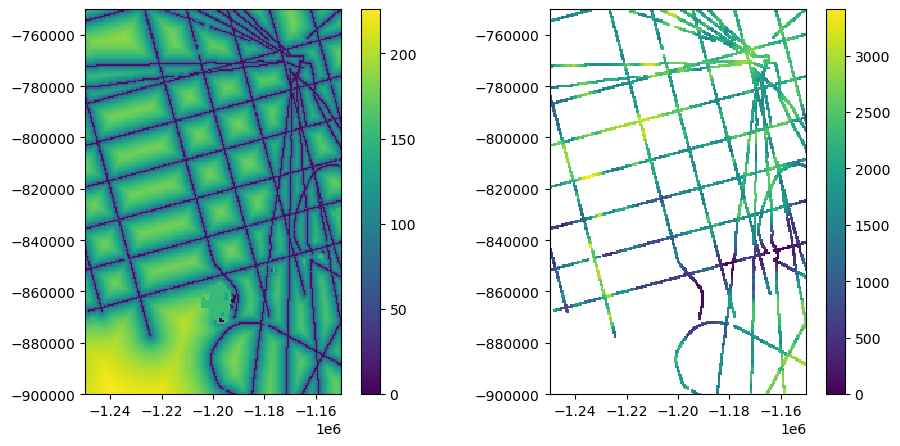

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(11,5))
ax = axs[0]
im = ax.pcolormesh(ds.x, ds.y, ds.thickness_uncertainty)
ax.axis('scaled')
plt.colorbar(im, ax=ax)
ax = axs[1]
im = ax.pcolormesh(ds.x, ds.y, ds.thick_cond)
ax.axis('scaled')
plt.colorbar(im, ax=ax)
plt.show()

In [6]:
thick_norm.shape

(300, 200)

In [7]:
thick_cond = ds.thick_cond.values
cond_msk = ~np.isnan(thick_cond)
xx, yy = np.meshgrid(ds.x, ds.y)
x_cond = xx[cond_msk]
y_cond = yy[cond_msk]
data_cond = thick_cond[cond_msk]

thick_norm, nst_trans = gaussian_transformation(thick_cond, cond_msk)
df_grid = pd.DataFrame({'X' : x_cond, 'Y' : y_cond, 'residual' : data_cond.squeeze(), 'NormZ' : thick_norm[cond_msk]})

In [8]:
# bins = [500, 1000, 2000, 4000, 6000, 8000, 10000, 13000, 16000, 20000, 25000, 30000, 50000]

In [9]:
%%time

vgrams, experimental, bins = do_variograms(xx, yy, ds.thick_cond.values, maxlag=50e3, n_lags=20, downsample=10)

CPU times: total: 1.16 s
Wall time: 1.17 s


In [10]:
# evaluate models
xi =np.linspace(0, bins[-1], 100) 

y_exp = models.exponential(xi, *vgrams['exponential'])
y_gauss = models.gaussian(xi, *vgrams['gaussian'])
y_sph = models.spherical(xi, *vgrams['spherical'])
y_matern = models.matern(xi, *vgrams['matern'])

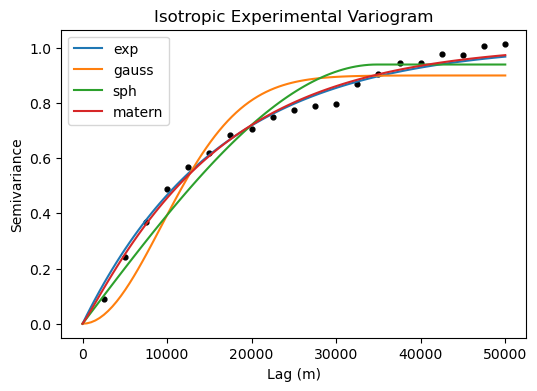

In [11]:
plt.figure(figsize=(6,4))
plt.scatter(bins, experimental, s=12, c='k')
plt.plot(xi, y_exp, label='exp')
plt.plot(xi, y_gauss, label='gauss')
plt.plot(xi, y_sph, label='sph')
plt.plot(xi, y_matern, label='matern')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.legend()
plt.show()

In [12]:
vgrams['matern']

[np.float64(44674.644394001516),
 np.float64(1.0143524402487438),
 np.float64(0.5589380051894247),
 0]

In [88]:
rng = np.random.default_rng(0)

parameters = vgrams['matern']

# set variogram parameters
nugget = parameters[-1]

# the major and minor ranges are the same in this example because it is isotropic
major_range = parameters[0]
minor_range = parameters[0]
sill = parameters[1]
smoothness = parameters[2]
nugget = parameters[-1]
azimuth = 0

# save variogram parameters as a list
vario = [azimuth, nugget, major_range, minor_range, sill, 'matern', smoothness]

k = 20
rad = 300e3

pred_grid = np.stack([xx.flatten(), yy.flatten()]).T
sim = gsm.Interpolation.okrige_sgs(pred_grid, df_grid, 'X', 'Y', 'NormZ', k, vario, rad, quiet=False, seed=rng)
sim_trans = nst_trans.inverse_transform(sim.reshape(-1,1)).squeeze()

100%|██████████| 60000/60000 [08:23<00:00, 119.20it/s]


In [89]:
thick_sim = sim_trans.reshape(xx.shape)

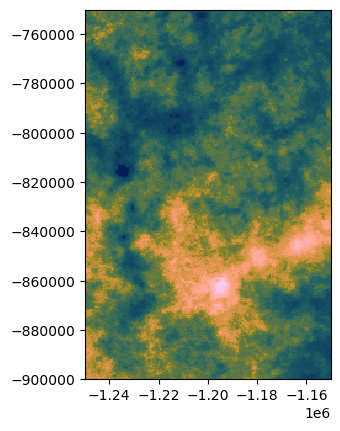

In [90]:
plt.pcolormesh(ds.x, ds.y, ds.surface_topography.values-thick_sim, cmap=cm.batlow)
plt.axis('scaled')
plt.show()

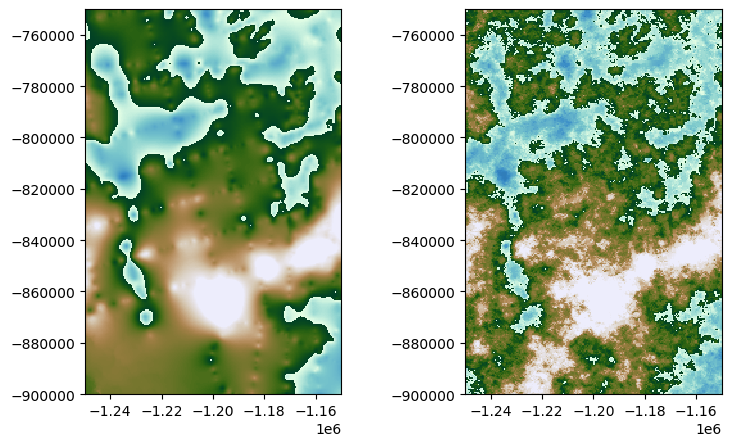

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(9,5))
ax = axs[0]
ax.pcolormesh(ds.x, ds.y, ds.bed_topography, cmap=cm.bukavu, vmin=-2000, vmax=2000)
ax.axis('scaled')
ax = axs[1]
ax.pcolormesh(ds.x, ds.y, ds.surface_topography.values-thick_sim, cmap=cm.bukavu, vmin=-2000, vmax=2000)
ax.axis('scaled')
plt.show()

In [38]:
from scipy.stats import qmc

bounds = [-1.25e6, -0.9e6, -1.15e6, -0.75e6]
l_bounds = bounds[:2]
u_bounds = bounds[2:]

sampler = qmc.LatinHypercube(d=2, optimization="random-cd")
sample = sampler.random(n=50)
rescaled = qmc.scale(sample, l_bounds, u_bounds)

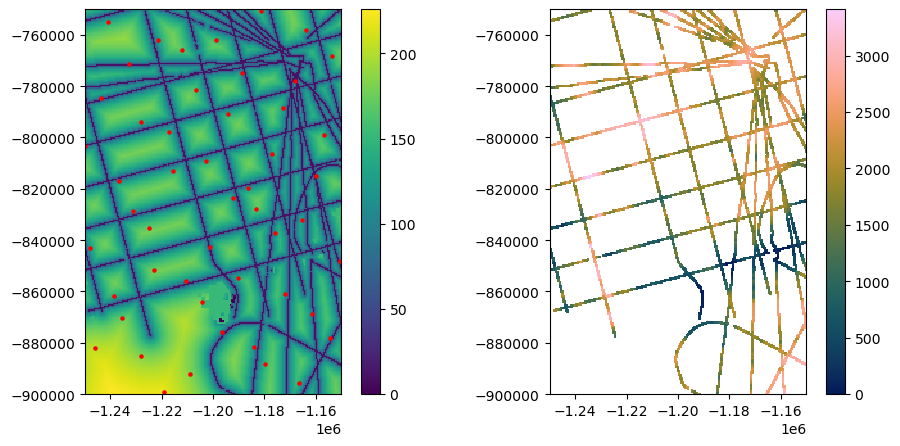

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(11,5))
ax = axs[0]
im = ax.pcolormesh(ds.x, ds.y, ds.thickness_uncertainty)
ax.axis('scaled')
ax.scatter(rescaled[:,0], rescaled[:,1], s=5, color='r')
plt.colorbar(im, ax=ax)
ax = axs[1]
im = ax.pcolormesh(ds.x, ds.y, ds.thick_cond, cmap=cm.batlow)
ax.axis('scaled')
plt.colorbar(im, ax=ax)
plt.show()

In [40]:
tmp = np.array([1, 2, 3, 4, 5])
tmp[[2, 4]]

array([3, 5])

In [41]:
mindist = 200e3
mindata = 500

n_points = rescaled.shape[0]

sizes = np.zeros(n_points)
var = np.zeros(n_points)
ranges = np.zeros(n_points)
sills = np.zeros(n_points)
smooths = np.zeros(n_points)
nuggets = np.zeros(n_points)

thick_values = thick_cond[cond_msk]
coordinates = (x_cond, y_cond)
coordinates_npy = np.array(coordinates).T

for i in tqdm(range(n_points)):
    # get cond data within distance of point
    dist = mindist
    n_cond = 0
    while n_cond < mindata:
        dist_msk = vd.distance_mask(rescaled[i], dist, coordinates)
        n_cond = thick_values[dist_msk].size
        dist += 10e3
        
    sizes[i] = thick_values[dist_msk].size
    var[i] = np.var(thick_values[dist_msk])

    data_cond = thick_values[dist_msk].reshape(-1,1)
    coords = coordinates_npy[dist_msk]

    inds = rng.integers(0, data_cond.shape[0]-1, mindata)
    data_cond = data_cond[inds]
    coords = coords[inds]

    # normal score transformation
    nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data_cond)
    norm_data = nst_trans.transform(data_cond).squeeze()

    # compute experimental (isotropic) variogram
    V = skg.Variogram(coords, norm_data, bin_func='even', n_lags=20, 
                   maxlag=70e3, normalize=False)
    V.model = 'matern'

    ranges[i] = V.parameters[0]
    sills[i] = V.parameters[1]
    smooths[i] = V.parameters[2]
    nuggets[i] = V.parameters[3]


    # plt.scatter(coordinates[0][dist_msk], coordinates[1][dist_msk], c=thick_values[dist_msk], s=1)
    # plt.axis('scaled')
    # plt.xlim(ds.x.values.min(), ds.x.values.max())
    # plt.ylim(ds.y.values.min(), ds.y.values.max())
    # plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

In [42]:
from scipy.interpolate import RBFInterpolator

In [43]:
var = np.array(var)

In [44]:
smoothing = 0

interp = RBFInterpolator(rescaled, var, smoothing=smoothing)
interp_vars = interp(np.array([xx.flatten(), yy.flatten()]).T).reshape(xx.shape)

interp = RBFInterpolator(rescaled, ranges, smoothing=smoothing)
interp_ranges = interp(np.array([xx.flatten(), yy.flatten()]).T).reshape(xx.shape)

interp = RBFInterpolator(rescaled, sills, smoothing=smoothing)
interp_sills = interp(np.array([xx.flatten(), yy.flatten()]).T).reshape(xx.shape)

interp = RBFInterpolator(rescaled, smooths, smoothing=smoothing)
interp_smooths = interp(np.array([xx.flatten(), yy.flatten()]).T).reshape(xx.shape)
interp_smooths = np.where(interp_smooths < 0, 0.1, interp_smooths)
interp_smooths = np.where(interp_smooths > 20, 20, interp_smooths)

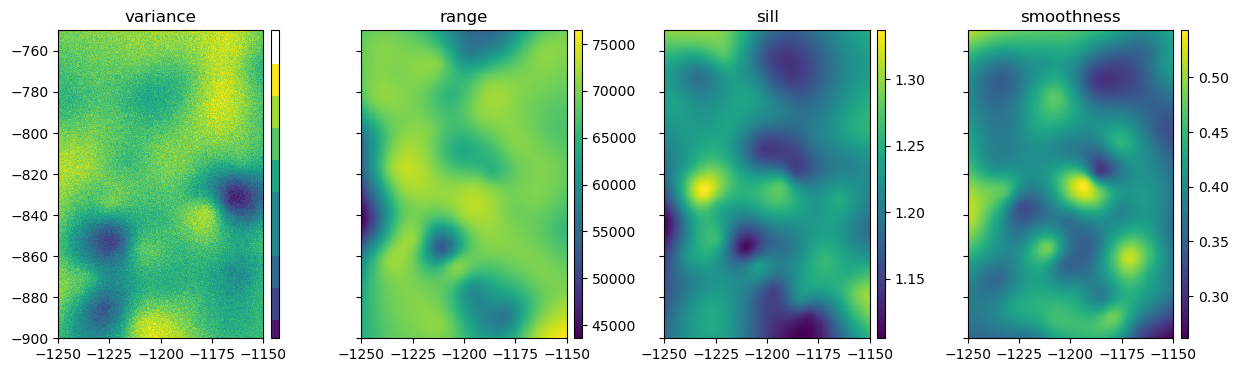

In [45]:
plots = [interp_vars, interp_ranges, interp_sills, interp_smooths]
titles = ['variance', 'range', 'sill', 'smoothness']

fig, axs = plt.subplots(1, 4, figsize=(15,4), sharey=True)

for p, ax, title in zip(plots, axs, titles):
    im = ax.pcolormesh(ds.x/1000, ds.y/1000, p)
    ax.axis('scaled')
    ax.set_title(title)
    plt.colorbar(im, ax=ax, pad=0.03, aspect=40)
plt.show()

In [46]:
interp = RBFInterpolator(rescaled, ranges)
interp_values = interp(np.array([xx.flatten(), yy.flatten()]).T).reshape(xx.shape)

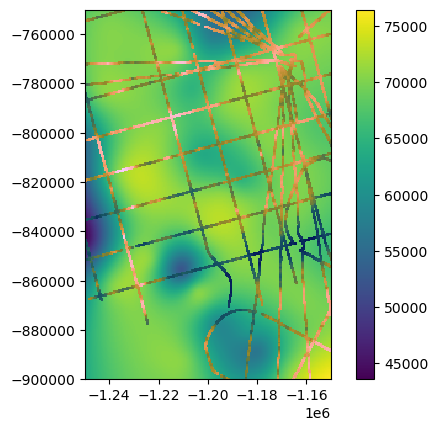

In [47]:
im = plt.pcolormesh(xx, yy, interp_values)
plt.pcolormesh(ds.x, ds.y, ds.thick_cond, cmap=cm.batlow)
plt.axis('scaled')
plt.colorbar(im)
plt.show()

In [48]:
# streamlines = gpd.read_file(Path('D:/bm3_streamlines_pt/bm3_streamlines_pt.shp'))

In [49]:
# fig, ax = plt.subplots(1, 1, figsize=(6,4))
# ax.pcolormesh(ds.x, ds.y, ds.bed_topography, cmap=cm.bukavu, vmin=-2000, vmax=2000)
# ax.axis('scaled')
# streamlines.plot(ax=ax, facecolor='none', edgecolor='r', markersize=2)
# plt.show()

In [91]:
# [azimuth, nugget, major_range, minor_range, sill, vtype, smoothness]
# vario = [azimuth, nugget, major_range, minor_range, sill, 'matern', smoothness]

rng = np.random.default_rng(0)

vario = {
    'azimuth' : 0,
    'nugget' : 0,
    'major_range' : major_range,
    'minor_range' : minor_range,
    'sill' : sill,
    'vtype' : 'matern',
    'smoothness' : smoothness
}

# vario = {
#     'azimuth' : 0,
#     'nugget' : 0,
#     'major_range' : interp_ranges,
#     'minor_range' : interp_ranges,
#     'sill' : interp_sills,
#     'vtype' : 'matern',
#     'smoothness' : interp_smooths
# }
# 
radius = 300e3
num_points = 20

sim_mask = np.full(xx.shape, True)
#sim_mask[100:110,50:60] = True

sim = sgs(xx, yy, thick_cond, vario, radius, num_points, sim_mask=sim_mask, seed=rng)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [92]:
np.allclose(thick_sim, sim)

False

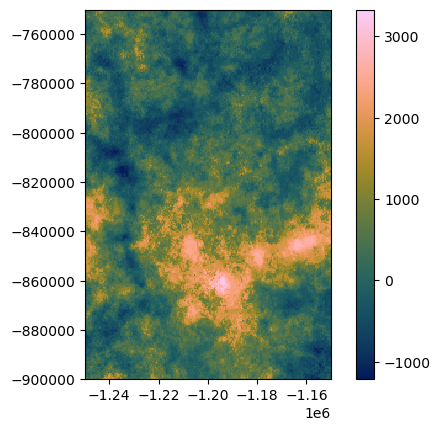

In [75]:
plt.pcolormesh(ds.x, ds.y, ds.surface_topography - sim, cmap=cm.batlow)
plt.axis('scaled')
plt.colorbar()
plt.show()

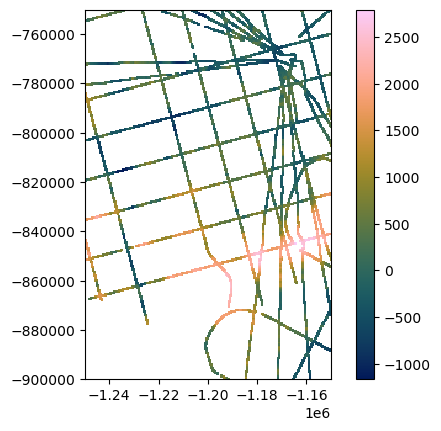

In [76]:
plt.pcolormesh(ds.x, ds.y, ds.surface_topography - thick_cond, cmap=cm.batlow)
plt.axis('scaled')
plt.colorbar()
plt.show()

In [77]:
vel = xr.open_dataset(Path('../stochastic_bathymetry/raw_data/phase_vel/antarctic_ice_vel_phase_map_v01.nc'))
vel = vel.sel(x=slice(-1.25e6, -1.15e6), y=slice(-0.75e6, -0.9e6))
vel

<xarray.Dataset> Size: 3MB
Dimensions:       (x: 222, y: 334)
Coordinates:
  * x             (x) float64 2kB -1.25e+06 -1.249e+06 ... -1.151e+06 -1.15e+06
  * y             (y) float64 3kB -7.5e+05 -7.505e+05 ... -8.994e+05 -8.999e+05
    lat           (y, x) float64 593kB ...
    lon           (y, x) float64 593kB ...
Data variables:
    coord_system  |S1 1B ...
    VX            (y, x) float32 297kB ...
    VY            (y, x) float32 297kB ...
    STDX          (y, x) float32 297kB ...
    STDY          (y, x) float32 297kB ...
    ERRX          (y, x) float32 297kB ...
    ERRY          (y, x) float32 297kB ...
    CNT           (y, x) int32 297kB ...
    SOURCE        (y, x) int8 74kB ...
Attributes: (12/27)
    Conventions:               CF-1.6
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary:  CF Standard Name Table (v22, 12 February 2013)
    id:                        v_mix.v8Jul2019.nc
    title:                     MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:            
    ...                        ...
    time_coverage_start:       1995-01-01
    time_coverage_end:         2016-12-31
    project:                   NASA/MEaSUREs
    creator_name:              J. Mouginot
    comment:                    
    license:                   No restrictions on access or use.

In [78]:
vel_coarse = vel.coarsen(x=20, y=20, boundary='trim').mean()

In [79]:
xx_vel, yy_vel = np.meshgrid(vel.x, vel.y)

kn = vd.KNeighbors(k=1)
kn.fit((xx_vel, yy_vel), vel.VX.values)
vx = kn.predict((xx, yy))

kn.fit((xx_vel, yy_vel), vel.VY.values)
vy = kn.predict((xx, yy))

vel_mag = np.sqrt(vx**2+vy**2)

In [140]:
ds['vx'] = (('y', 'x'), vx)
ds['vy'] = (('y', 'x'), vy)

ds.to_netcdf('test_data.nc')

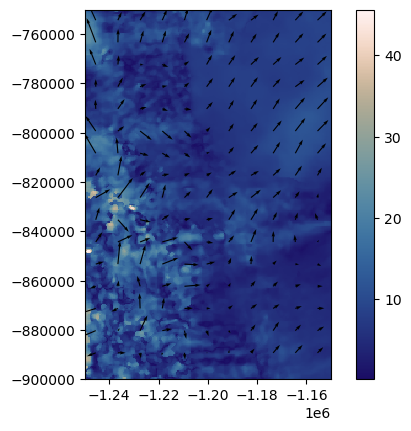

In [80]:
im = plt.pcolormesh(ds.x, ds.y, vel_mag, cmap=cm.lapaz)
plt.quiver(vel_coarse.x, vel_coarse.y, vel_coarse.VX, vel_coarse.VY)
plt.axis('scaled')
plt.colorbar(im)
plt.show()

In [81]:
vel_angle = np.arctan2(vy, vx)*180/np.pi
rescale_mag = rescale(vel_mag, 1, 2)

In [82]:
vario = {
    'azimuth' : vel_angle,
    'nugget' : 0,
    'major_range' : interp_ranges,
    'minor_range' : interp_ranges/rescale_mag,
    'sill' : interp_sills,
    'vtype' : 'matern',
    'smoothness' : interp_smooths
}

radius = 300e3
num_points = 20

sim_mask = np.full(xx.shape, True)
#sim_mask[100:110,50:60] = True

sim = sgs(xx, yy, thick_cond, vario, radius, num_points, sim_mask=sim_mask, seed=rng)

  0%|          | 0/60000 [00:00<?, ?it/s]

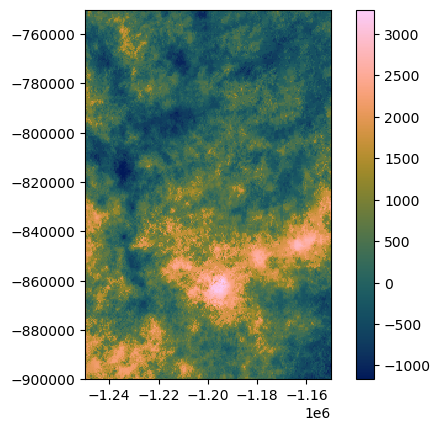

In [83]:
plt.pcolormesh(ds.x, ds.y, ds.surface_topography - sim, cmap=cm.batlow)
plt.axis('scaled')
plt.colorbar()
plt.show()

In [84]:
ds2 = xr.open_dataset(Path('../bedmap/bedmap3_mod.nc'))
ds2 = ds2.sel(x=slice(2.25e6, 2.65e6), y=slice(-0.25e6, -0.6e6))
ds2

<xarray.Dataset> Size: 34MB
Dimensions:                 (x: 800, y: 700)
Coordinates:
  * x                       (x) float32 3kB 2.25e+06 2.251e+06 ... 2.65e+06
  * y                       (y) float32 3kB -2.502e+05 -2.508e+05 ... -5.998e+05
Data variables:
    surface_topography      (y, x) float32 2MB ...
    bed_uncertainty         (y, x) float32 2MB ...
    bed_topography          (y, x) float32 2MB ...
    mask                    (y, x) float32 2MB ...
    ice_thickness           (y, x) float32 2MB ...
    thickness_survey_count  (y, x) float32 2MB ...
    thickness_uncertainty   (y, x) float32 2MB ...
    mapping                 <U19 76B ...
    geoid                   (y, x) float64 4MB ...
    bed_ell                 (y, x) float64 4MB ...
    surface_ell             (y, x) float64 4MB ...
    thick_cond              (y, x) float64 4MB ...
Attributes: (12/26)
    crs:                    EPSG:3031
    title:                  BEDMAP3 - Ice thickness, bed and surface elevatio...
    summary:                We present here Bedmap3, the latest suite of grid...
    keywords:               Antarctica,BEDMAP,Elevation,Ice thickness
    Conventions:            ACDD-1.3, CF-1.8
    citation:               Pritchard, H., Fretwell, P., Fremand, A., Bodart,...
    ...                     ...
    time_coverage_end:      2024-11-01
    geospatial_lon_min:     -180
    geospatial_lon_max:     180
    geospatial_lat_min:     -90
    geospatial_lat_max:     -60
    geospatial_bounds_crs:  EPSG:4326

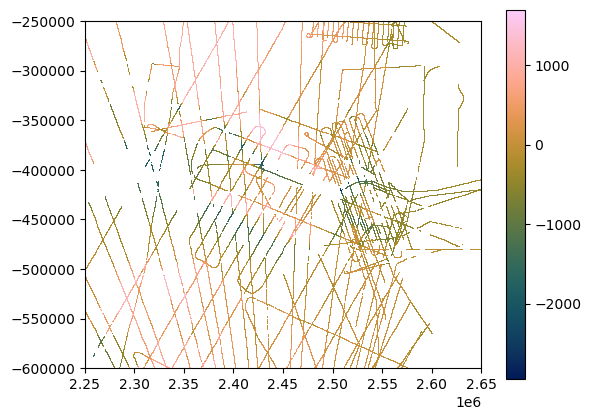

In [85]:
plt.pcolormesh(ds2.x, ds2.y, ds2.surface_topography - ds2.thick_cond, cmap=cm.batlow)
plt.axis('scaled')
plt.colorbar()
plt.show()

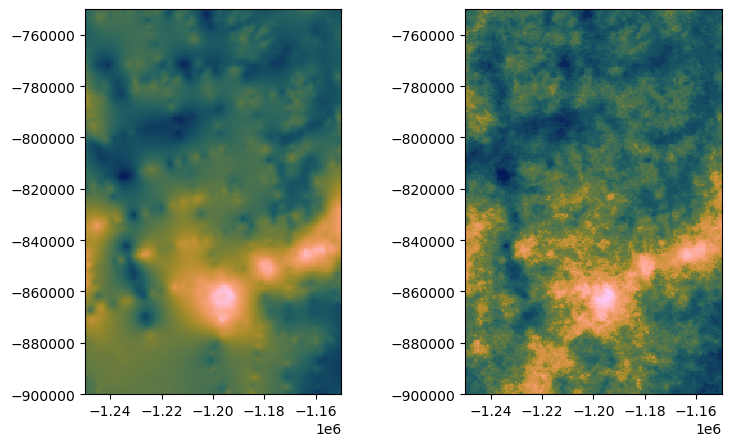

In [87]:
sim_bed = ds.surface_topography.values-thick_sim

vmin = np.min(sim_bed)
vmax = np.max(sim_bed)

fig, axs = plt.subplots(1, 2, figsize=(9,5))
ax = axs[0]
ax.pcolormesh(ds.x, ds.y, ds.bed_topography, cmap=cm.batlow, vmin=vmin, vmax=vmax)
ax.axis('scaled')
ax = axs[1]
ax.pcolormesh(ds.x, ds.y, ds.surface_topography.values-thick_sim, cmap=cm.batlow, vmin=vmin, vmax=vmax)
ax.axis('scaled')
plt.show()

In [95]:
xx.shape

(300, 200)

In [96]:
thick_cond = ds.thick_cond.values[100:200,50:150]
xx_trim = xx[100:200,50:150]
yy_trim = yy[100:200,50:150]

cond_msk = ~np.isnan(thick_cond)
x_cond = xx_trim[cond_msk]
y_cond = yy_trim[cond_msk]
data_cond = thick_cond[cond_msk]

thick_norm, nst_trans = gaussian_transformation(thick_cond, cond_msk)
df_grid = pd.DataFrame({'X' : x_cond, 'Y' : y_cond, 'residual' : data_cond.squeeze(), 'NormZ' : thick_norm[cond_msk]})

In [99]:
rng = np.random.default_rng(0)

parameters = vgrams['matern']

# set variogram parameters
nugget = parameters[-1]

# the major and minor ranges are the same in this example because it is isotropic
major_range = parameters[0]
minor_range = parameters[0]
sill = parameters[1]
smoothness = parameters[2]
nugget = parameters[-1]
azimuth = 0

# save variogram parameters as a list
vario = [azimuth, nugget, major_range, minor_range, sill, 'matern', smoothness]

k = 20
rad = 300e3

pred_grid = np.stack([xx_trim.flatten(), yy_trim.flatten()]).T
sim = gsm.Interpolation.okrige_sgs(pred_grid, df_grid, 'X', 'Y', 'NormZ', k, vario, rad, quiet=False, seed=rng)
sim_trans = nst_trans.inverse_transform(sim.reshape(-1,1)).squeeze()

100%|██████████| 10000/10000 [01:06<00:00, 150.47it/s]


In [130]:
rng = np.random.default_rng(0)

vario = {
    'azimuth' : 0,
    'nugget' : 0,
    'major_range' : major_range,
    'minor_range' : minor_range,
    'sill' : sill,
    'vtype' : 'matern',
    'smoothness' : smoothness
}

radius = 300e3
num_points = 20

sim = sgs(xx_trim, yy_trim, thick_cond, vario, rad, k, seed=rng)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [131]:
thick_sim = sim_trans.reshape(xx_trim.shape)

In [132]:
np.allclose(thick_sim, sim)

False

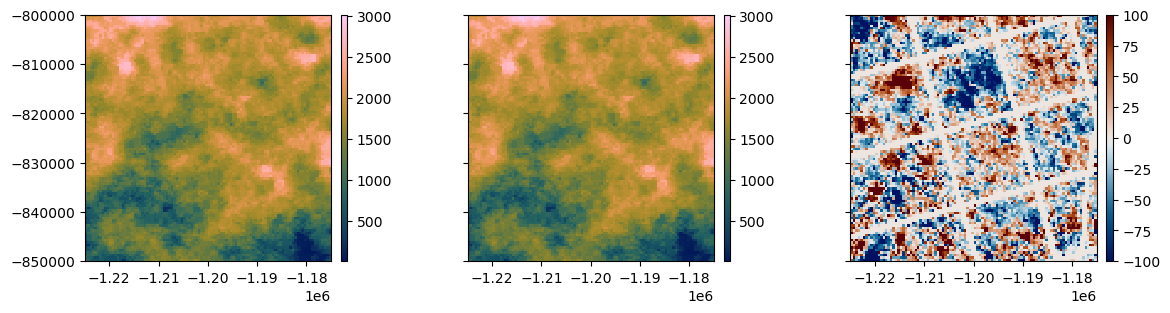

In [133]:
vmin = np.min(thick_sim)
vmax = np.max(thick_sim)

fig, axs = plt.subplots(1, 3, figsize=(14,3.2), sharey=True)
ax = axs[0]
im = ax.pcolormesh(xx_trim, yy_trim, thick_sim, vmin=vmin, vmax=vmax, cmap=cm.batlow)
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(xx_trim, yy_trim, thick_sim, vmin=vmin, vmax=vmax, cmap=cm.batlow)
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[2]
im = ax.pcolormesh(xx_trim, yy_trim, thick_sim-sim, vmin=-100, vmax=100, cmap=cm.vik)
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

plt.show()

In [116]:
sims = np.zeros((100, *thick_cond.shape))

for i in tqdm(range(100)):
    sim = sgs(xx_trim, yy_trim, thick_cond, vario, rad, k, seed=rng, quiet=True)
    sims[i] = sim

  0%|          | 0/100 [00:00<?, ?it/s]

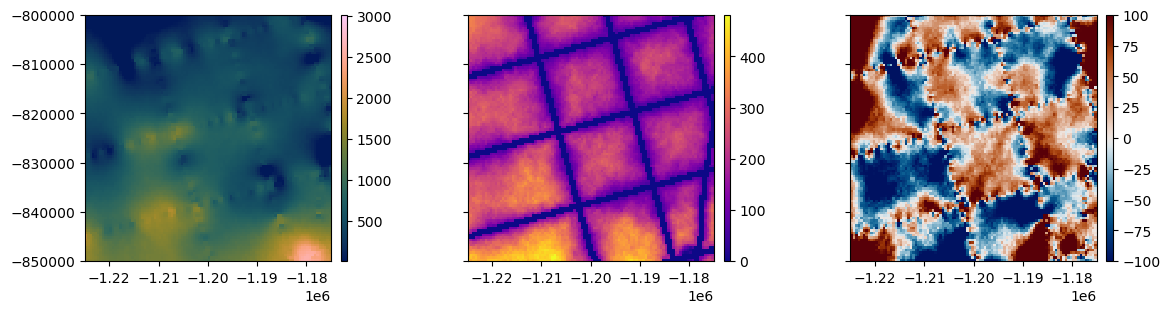

In [128]:
surf_trim = ds.surface_topography.values[100:200,50:150]
bed_trim = ds.bed_topography.values[100:200,50:150]

vmin = np.min(thick_sim)
vmax = np.max(thick_sim)

fig, axs = plt.subplots(1, 3, figsize=(14,3.2), sharey=True)
ax = axs[0]
im = ax.pcolormesh(xx_trim, yy_trim, surf_trim-np.mean(sims, axis=0), vmin=vmin, vmax=vmax, cmap=cm.batlow)
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(xx_trim, yy_trim, np.std(sims, axis=0), cmap='plasma')
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[2]
im = ax.pcolormesh(xx_trim, yy_trim, (surf_trim-bed_trim) - np.mean(sims, axis=0), vmin=-100, vmax=100, cmap=cm.vik)
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

plt.show()

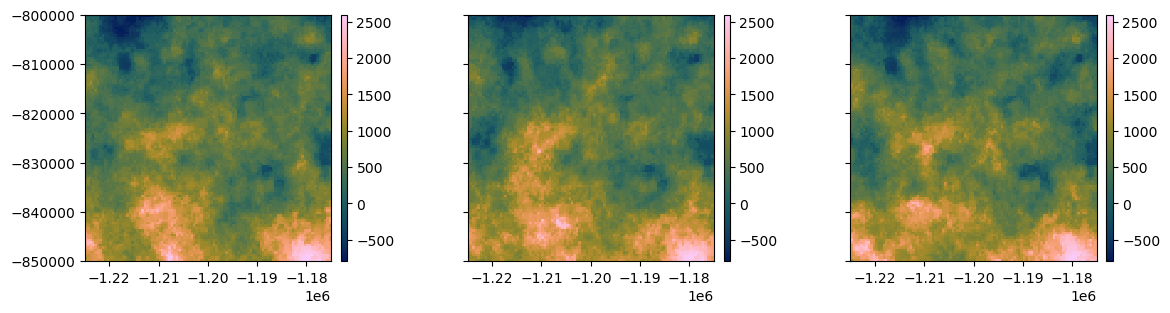

In [123]:
vmin = np.min(surf_trim - thick_sim)
vmax = np.max(surf_trim - thick_sim)

fig, axs = plt.subplots(1, 3, figsize=(14,3.2), sharey=True)
ax = axs[0]
im = ax.pcolormesh(xx_trim, yy_trim, surf_trim-sims[0], vmin=vmin, vmax=vmax, cmap=cm.batlow)
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(xx_trim, yy_trim, surf_trim-sims[1], vmin=vmin, vmax=vmax, cmap=cm.batlow)
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[2]
im = ax.pcolormesh(xx_trim, yy_trim, surf_trim-sims[2], vmin=vmin, vmax=vmax, cmap=cm.batlow)
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

plt.show()

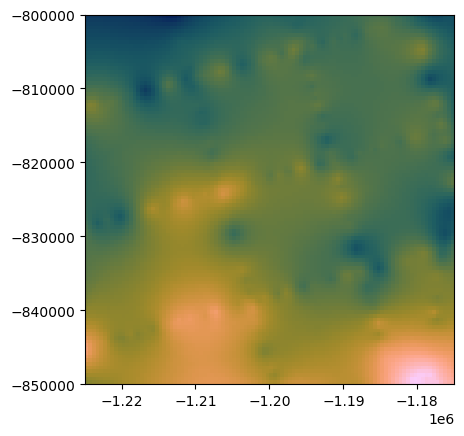

In [125]:
plt.pcolormesh(xx_trim, yy_trim, bed_trim, vmin=vmin, vmax=vmax, cmap=cm.batlow)
plt.axis('scaled')
plt.show()